In [3]:
def get_datagen(path, input_resolution=(224, 224), batch_size=2):
    """
    train,validation,test data_generator 를 반환합니다.
    path 는 train,validation,test 디렉토리를 포함하는 경로입니다.
    각 하위 데이터셋은 라벨당 폴더별로 이미지가 저장되어있습니다.
    특정(e.g validation) 하위디렉토리가 없을시에는 해당 data_generator는 None으로 반환됩니다.

    :param path: directory include train,validation,test folder
    """
    train_gen=None
    validation_gen=None
    test_gen=None

    train_dir = path + '/train'
    validation_dir = path + '/validation'
    test_dir = path + '/test'

    # 데이터 준비
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip=True,
#                                        zca_whitening=True,
                                       rotation_range=20,
                                       width_shift_range=0.1,
                                      height_shift_range=0.1
                                      )
    validation_datagen = ImageDataGenerator(rescale=1. / 255)
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    if os.path.exists(train_dir):
        train_gen = train_datagen.flow_from_directory(
            train_dir,
            target_size=input_resolution,
            batch_size=batch_size,
            class_mode='binary')
    if os.path.exists(validation_dir):
        validation_gen = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=input_resolution,
            batch_size=batch_size,
            class_mode='binary')
    if os.path.exists(test_dir):
        test_gen = test_datagen.flow_from_directory(
            test_dir,
            target_size=input_resolution,
            batch_size=batch_size,
            class_mode='binary')

    return train_gen, validation_gen, test_gen

In [5]:
import sys;sys.path.insert(0,'/home/snapsmaster/jupyter_server/common')
from common.util.keras_util import SnapsKerasUtil
from keras.preprocessing.image import ImageDataGenerator
import os

### Init parameter

In [6]:
#파라미터 정의
batch_size=2
input_shape=(224,224,3)
n_classes = 2
epoch=100
data_dir = './data'

### Set data

In [101]:
train_gen = SnapsKerasUtil.getGenerator_fromDirectory('data/train',input_shape[:2],batch_size)
validation_gen = SnapsKerasUtil.getGenerator_fromDirectory('data/validation',input_shape[:2],batch_size)
test_gen = SnapsKerasUtil.getGenerator_fromDirectory('data/test',input_shape[:2],batch_size)

Found 106 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


NameError: name 'SnapsError' is not defined

In [7]:
train_gen,validation_gen,test_gen = get_datagen('data',input_shape[:2],batch_size)

Found 106 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [9]:
train_step = SnapsKerasUtil.get_generatorStep(train_gen)*4
validation_step = SnapsKerasUtil.get_generatorStep(validation_gen)*4

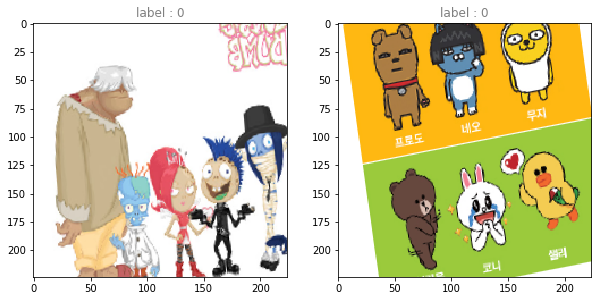

In [10]:
SnapsKerasUtil.show_generator(train_gen,color_mode='rgb',cols=2)

### Modeling orinet 

In [11]:
from keras.models import Model,Sequential
from keras.layers import Conv2D,Dense,Input,MaxPooling2D,Activation,Dropout,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.mobilenetv2 import MobileNetV2

In [29]:
model = MobileNetV2(input_shape=input_shape, include_top=False,weights='imagenet')

In [30]:
for layer in model.layers[:-3]:
    layer.trainable=False
for layer in model.layers[-3:]:
    print(layer)

In [31]:
x = model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model.input, outputs=output)

### Compile model

In [32]:
model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (Activation)         (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

### Get callbacks

In [34]:
callbacks = SnapsKerasUtil.get_callback(use_ckpt=True, ckpt_path='./checkpoint',
                      use_early_stop=True, early_stop_patience=5,
                        use_learning_rate_scheduler=True, lr_rate=1e-4, lr_decay=0.9)

### Train

In [35]:
# 모델 학습시키기
history = model.fit_generator(
        generator= train_gen,
        steps_per_epoch=train_step*4,
        epochs=epoch,
        validation_data=validation_gen,
        validation_steps=validation_step*4,
        callbacks=callbacks,
        verbose=1
        )

Epoch 1/100
 51/848 [>.............................] - ETA: 1:33 - loss: 0.6307 - acc: 0.6275

/home/snapsmaster/.pyenv/versions/3.6.1/envs/hian/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


848/848 [==============================] - 45s 53ms/step - loss: 0.4311 - acc: 0.7647 - val_loss: 0.6972 - val_acc: 0.7656
Epoch 2/100
848/848 [==============================] - 40s 47ms/step - loss: 0.3087 - acc: 0.8550 - val_loss: 0.8553 - val_acc: 0.7690
Epoch 3/100
848/848 [==============================] - 40s 47ms/step - loss: 0.2590 - acc: 0.8962 - val_loss: 0.9668 - val_acc: 0.7184
Epoch 4/100
848/848 [==============================] - 40s 47ms/step - loss: 0.2127 - acc: 0.9257 - val_loss: 0.7776 - val_acc: 0.7707
Epoch 5/100
848/848 [==============================] - 40s 47ms/step - loss: 0.1732 - acc: 0.9499 - val_loss: 0.9444 - val_acc: 0.7673
Epoch 6/100
848/848 [==============================] - 39s 46ms/step - loss: 0.1704 - acc: 0.9458 - val_loss: 0.8156 - val_acc: 0.7943
Epoch 7/100
848/848 [==============================] - 40s 47ms/step - loss: 0.1324 - acc: 0.9676 - val_loss: 1.0100 - val_acc: 0.7943
Epoch 8/100
848/848 [==============================] - 40s 47ms/ste

In [94]:
model.save('tori2.h5')

In [85]:
from time import time
def test_model(model,img_list=None,label_list=None,test_generator=None, cols=4, figsize=(10, 10), steps=1,rescale=None,color_mode='rgb'):
    """
    test_generator.batch_size >= rows*cols

    """
    x_list=[]
    y_list=[]
    input_shape = tuple(np.array(model.input.shape[1:]).astype(int))

    if img_list is None:

        for _ in range(steps):
            try:
                x, y = test_generator.next()
            except:
                x = test_generator.next()

            x_list.extend(x)
            y_list.extend(y)

    elif test_generator is None:

        if color_mode == 'rgb':
            img_list = [v[..., ::-1] for v in img_list]
        if rescale:
            img_list = [v * rescale for v in img_list]

        img_list = [cv2.resize(v,(input_shape[0],input_shape[1])) for v in img_list]

        x_list.extend(img_list)

        if label_list is None:
            y_list.extend([-1 for _ in range(len(img_list))])
        else:
            y_list.extend(label_list)

    rows = len(x_list)//cols+1

    for row in range(rows):

        fig = plt.figure(figsize=figsize)

        for i in range(cols):

            idx = row * cols + i
            if idx>=len(x_list):
                break

            tic = time()
            x_ = x_list[idx].reshape((1, input_shape[0], input_shape[1], input_shape[2]))
            output = model.predict(x_)
            toc = time()

            frame = fig.add_subplot(1, cols, i + 1)
            predict_idx = np.argmax(output[0])
            if y_list[idx] != -1:
                title = 'T:{} P:{} - {}ms\n{:.2f}%'.format(np.argmax(y_list[idx]), predict_idx, int(((toc - tic) * 1000)),output[0][predict_idx] * 100)

                if np.argmax(y_list[idx]) == predict_idx:
                    frame.set_title(title, fontsize=figsize[0], color='#808080')
                else:
                    frame.set_title(title, fontsize=figsize[0], color='#FF00FF')

            else:
                title = 'Pred:{} - {}ms\n{:.2f}%'.format(predict_idx,int(((toc - tic) * 1000)),output[0][predict_idx] * 100)

                frame.set_title(title, fontsize=figsize[0], color='#808080')

            frame.set_xticks([])
            frame.set_yticks([])
            frame.imshow(x_list[idx])

        plt.show()


In [86]:
from util.image_util import SnapsImageUtil
import cv2

In [89]:
path_list = SnapsImageUtil.get_pathlist('/home/snapsmaster/hian/tori_detection/data/validation/tori')
img_list = [cv2.imread(path) for path in path_list]

In [95]:
path_list[0]

'/home/snapsmaster/hian/tori_detection/data/validation/tori/tori_money.jpeg'

In [97]:
import numpy as np

In [106]:
!ls /home/snapsmaster/hian/tori_detection/data/validation/else/

0c9ed79a_2a51_4283_8903_30fb9abcb596.png
1VE5F3W5WP_18.png
2038941605_vjzpZhmV_2.png
73554141c7c641a4989a1c6e536a4bd7.png
8382c745fc270899365c8f4fd4d07db9.png
8d7fdc0c6eacb43fe1fc466e03408b95.png
CHAR_201808060311448750.png
DJi0D_PVoAI_eub.png
cha_Snorkmaiden.png
character_design03_1.png
e76c4dc78b0e71f07723a82ecb75bd02.png
f131587439966201091(0).png
fd7e28e5_5768_49bf_b172_82404b00b889.png
htm_20150216175457142.jpg
hy.jpg
icon_character_cate_023.png
main_crt3.png
main_crt6.png
maxresdefault.jpg


In [114]:
img = cv2.imread(path_list[0])
img = cv2.imread('/home/snapsmaster/hian/tori_detection/data/validation/else/maxresdefault.jpg')
img = img[...,::-1]/255.
img = cv2.resize(img,(224,224))
img = np.expand_dims(img,0)

In [115]:
prediction = model.predict(img)

In [116]:
prediction

array([[0.04180983]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


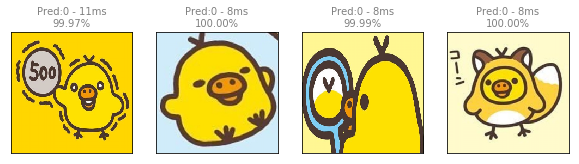

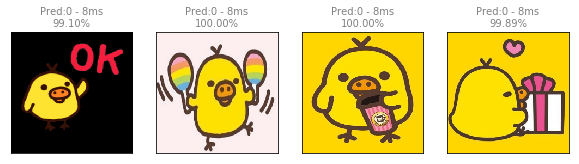

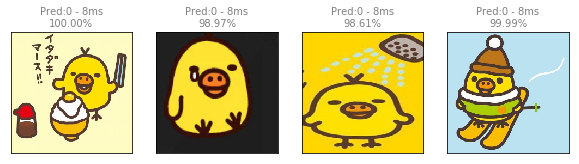

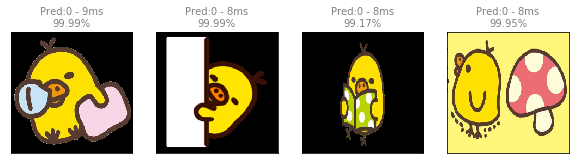

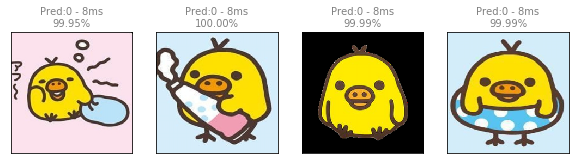

<Figure size 720x720 with 0 Axes>

In [93]:
test_model(model,img_list=img_list,cols=4,rescale=1/255)

### Plot graph of result

In [127]:
!pip freeze | grep Ke

You are using pip version 9.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Keras==2.2.0
Keras-Applications==1.0.2
Keras-Preprocessing==1.0.1


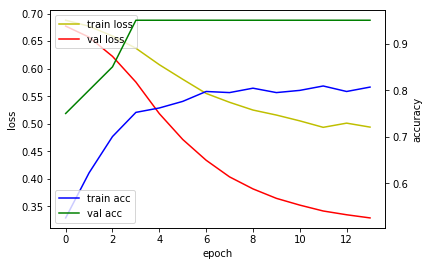

In [114]:
SnapsKerasUtil.plot_history(history)

### Test model

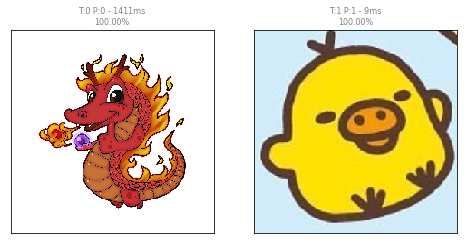

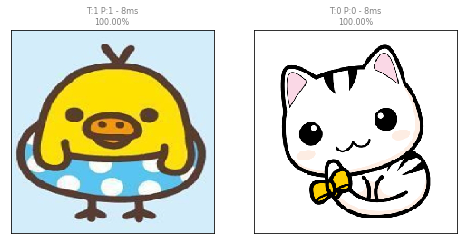

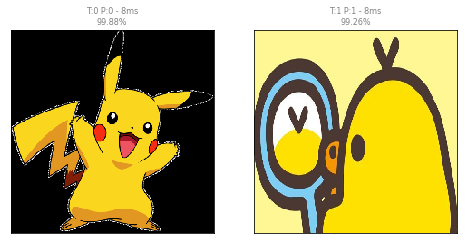

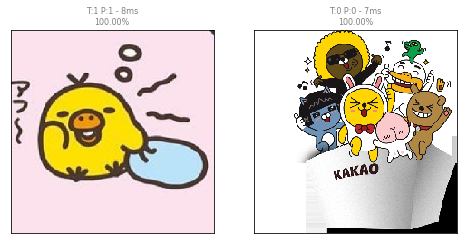

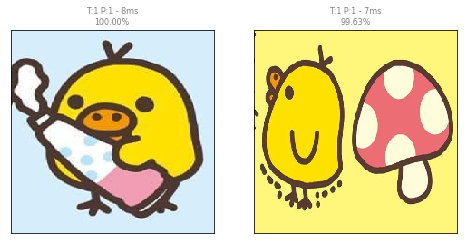

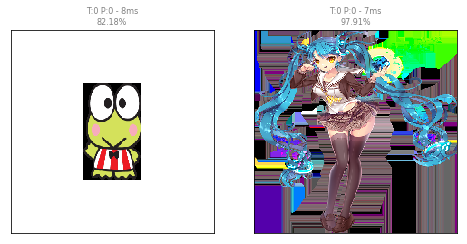

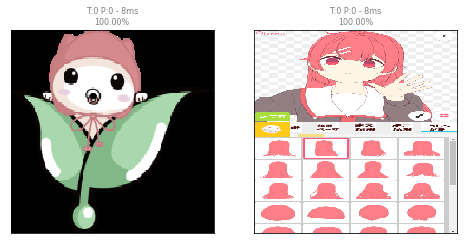

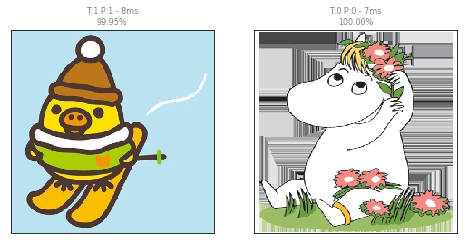

In [122]:
# 확인
SnapsKerasUtil.test_model(validation_gen,model,rows=1,cols=2,steps=8,figsize=(8,8),color_mode='rgb')

In [46]:
# evaluate_model(test_gen,model)
score = model.evaluate_generator(test_gen,steps=train_step)
print()
print("loss: {}%".format(round(score[0], 3)), end='\t')
print("acc: {}%".format(round(score[1], 3) * 100), end='\n\n')


loss: 0.16%	acc: 94.69999999999999%



### Test Loaded Model

##### load model

In [4]:
load_model_name = './models/orinet'
loaded_model = load_model(load_model_name,False)

##### test

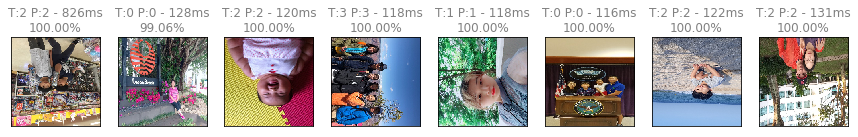

<Figure size 1080x1080 with 0 Axes>

model is not compiled...
compile model and restart..[optimizer=adam, loss=categorical_crossentropy]

loss: 0.049%	acc: 98.5%



In [5]:
# 모델 테스트
test_model(test_gen,loaded_model,figsize=(15,15),steps=1)
evaluate_model(test_gen,loaded_model)

### Show CAM

In [126]:
SnapsKerasUtil.show_cam(validation_gen,model,show_layer_idx=-3,figsize=(20,20),max_idx=16)

([array([[[1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          ...,
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ]],
  
         [[1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          ...,
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ]],
  
         [[1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          ...,
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ],
          [1.        , 0.83921576, 0.        ]],
  
         ...,
  
         [[1.        , 0.83921576, 0.        ],
          [1. 

### Show below 95%

Total Image N :43 
Selected Image Idx : 5~36


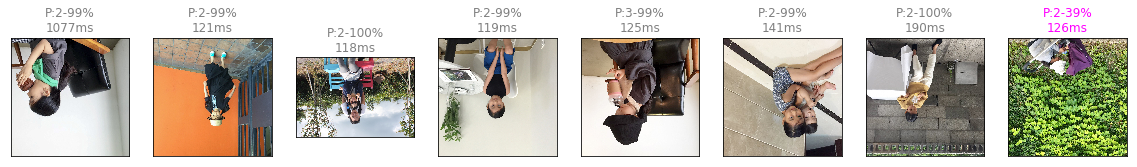

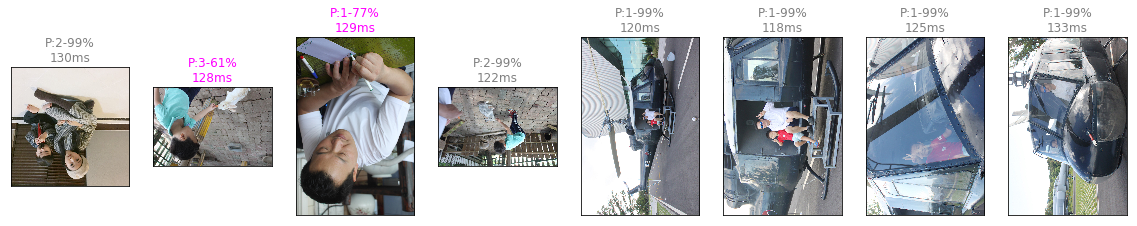

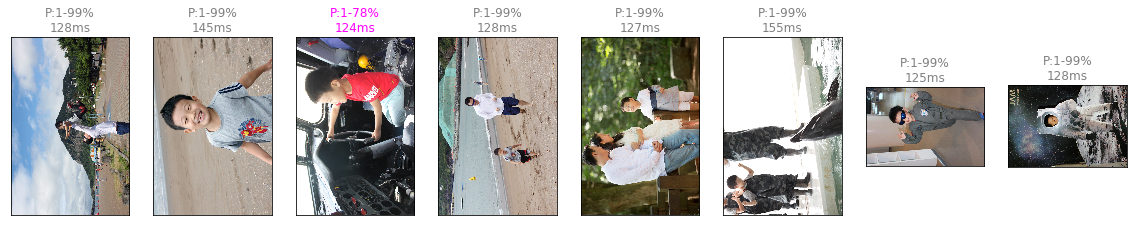

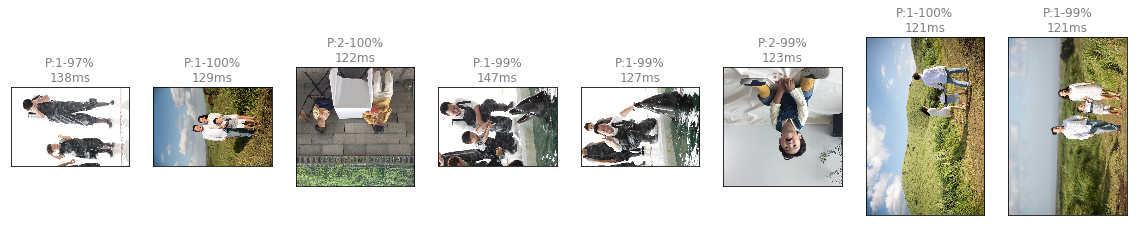

predict done.
Total Image N (Below 95.0%) : 4/32 - 12%


In [8]:
show_result('/Users/hian/Desktop/sample',loaded_model,show_below=True)

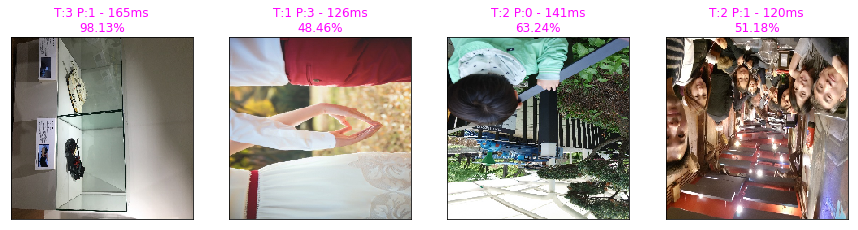

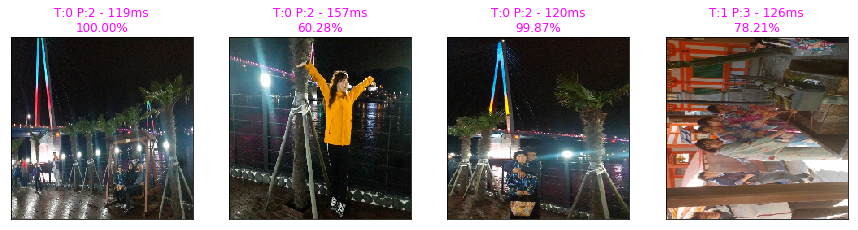

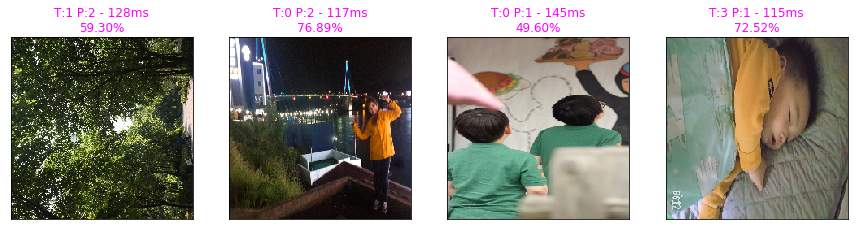

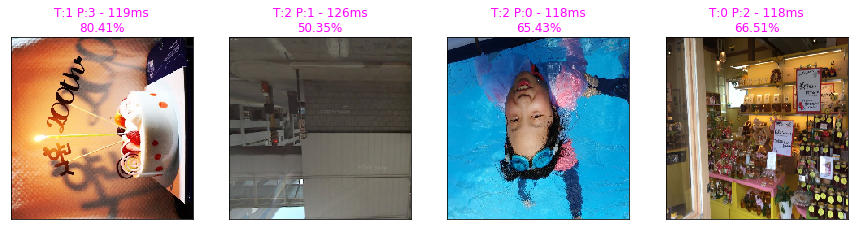

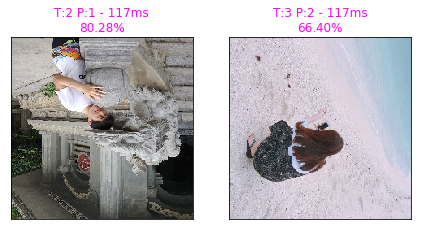

find 2 different prediction 


In [9]:
show_diff_result(test_gen,loaded_model,steps=20)